In [23]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import onnxruntime as ort
from matplotlib import pyplot as plt

from utils.Dataset import CraneDataset
from utils.miscellaneous import create_seq_dataset_multiple_input_single_output
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from tqdm.notebook import tqdm

In [24]:
model = ort.InferenceSession('models/model_25.onnx')

In [25]:
data_file_path_list = []
data_file_name_list = os.listdir('data')

for file_name in data_file_name_list:
    data_file_path_list.append(os.path.join('data', file_name))

dataset_inst = CraneDataset(data_file_path_list)
raw_dataset = dataset_inst.get_dataset()
dataset = raw_dataset.copy()
dataset = dataset.iloc[0::10]
dataset.reset_index(drop=True, inplace=True)

feature_name_list = dataset_inst.get_data_feature_names()
target_name_list = dataset_inst.get_data_target_names()

for target_name in target_name_list:
    dataset[target_name] = dataset[target_name]/1000

  0%|          | 0/22 [00:00<?, ?it/s]

In [26]:
# 0: 0.4
# 45: 0.4
# 90: 0.2
# 135 : 0.4
# 180: 0.2

In [27]:
ref_swing_angle_list = np.array([0, 45, 90, 135, 180, 225, 270, 315, 360])
target_load_ratio_list = np.array([0.3, 0.4, 0.2, 0.4, 0.3, 0.4, 0.2, 0.4, 0.3])

left_load_name_list = ['Actual_Load_Left_1(N)', 'Actual_Load_Left_2(N)', 'Actual_Load_Left_3(N)', 'Actual_Load_Left_4(N)', 'Actual_Load_Left_5(N)']
right_load_name_list = ['Actual_Load_Right_1(N)', 'Actual_Load_Right_2(N)', 'Actual_Load_Right_3(N)', 'Actual_Load_Right_4(N)', 'Actual_Load_Right_5(N)']

front_load_name_list = ['Actual_Load_Left_1(N)', 'Actual_Load_Left_2(N)', 'Actual_Load_Right_1(N)', 'Actual_Load_Right_2(N)']
rear_load_name_list = ['Actual_Load_Left_4(N)', 'Actual_Load_Left_5(N)', 'Actual_Load_Right_4(N)', 'Actual_Load_Right_5(N)']

left_load_idx_list = [0, 1, 2, 3, 4]
right_load_idx_list = [5, 6, 7, 8, 9]

front_load_idx_list = [0, 1, 5, 6]
rear_load_idx_list = [3, 4, 8, 9]

mean_left_load_list = []
mean_right_load_list = []
mean_front_load_list = []
mean_rear_load_list = []
roll_over_det_list = []

n_file = int(dataset['file_idx'].max()+1)

for file_idx in tqdm(range(n_file)):
    data_sample = dataset[dataset['file_idx']==file_idx]

    for i in range(data_sample.shape[0]):
        sample = data_sample.iloc[i, :]
        load_arr = sample[left_load_name_list+right_load_name_list].to_numpy()
        swing_angle = sample['Swing_Angle(deg)'].item()
        target_load_ratio = np.interp(swing_angle, ref_swing_angle_list, target_load_ratio_list)


        mean_left_load = np.mean(load_arr[left_load_idx_list])
        mean_right_load = np.mean(load_arr[right_load_idx_list])
        mean_front_load = np.mean(load_arr[front_load_idx_list])
        mean_rear_load = np.mean(load_arr[rear_load_idx_list])
        mean_total_load = np.mean(load_arr)
        mean_front_rear_load = np.mean(load_arr[front_load_idx_list+rear_load_idx_list])

        left_load_margin = mean_left_load/mean_total_load
        right_load_margin = mean_right_load/mean_total_load
        front_load_margin = mean_front_load/mean_front_rear_load
        rear_load_margin = mean_rear_load/mean_front_rear_load

        roll_over_det = (left_load_margin < target_load_ratio) | (right_load_margin < target_load_ratio) | (front_load_margin < target_load_ratio) | (rear_load_margin < target_load_ratio)
        roll_over_det = roll_over_det.astype(int)

        mean_left_load_list.append(mean_left_load)
        mean_right_load_list.append(mean_right_load)
        mean_front_load_list.append(mean_front_load)
        mean_rear_load_list.append(mean_rear_load)
        roll_over_det_list.append(roll_over_det)

mean_left_load_arr = np.array(mean_left_load_list)
mean_right_load_arr = np.array(mean_right_load_list)
mean_front_load_arr = np.array(mean_front_load_list)
mean_rear_load_arr = np.array(mean_rear_load_list)
roll_over_det_arr = np.array(roll_over_det_list)

dataset = pd.concat([dataset, pd.DataFrame(roll_over_det_arr, columns=['roll_over_det'])], axis=1)

print(dataset.shape)

  0%|          | 0/22 [00:00<?, ?it/s]

(9091, 21)


In [28]:
dataset

,Time(sec),file_idx,safe_state,dataset_type,Boom_Angle(deg),Swing_Angle(deg),Load(Ton),Roll_Angle(deg),Yaw_Angle(deg),Pitch_Angle(deg),...,Actual_Load_Left_2(N),Actual_Load_Left_3(N),Actual_Load_Left_4(N),Actual_Load_Left_5(N),Actual_Load_Right_1(N),Actual_Load_Right_2(N),Actual_Load_Right_3(N),Actual_Load_Right_4(N),Actual_Load_Right_5(N),roll_over_det
0,0.000000,0.0,0.0,0.0,70.000000,0.000000e+00,40.0,0.000000e+00,0.000000,0.000000,...,-1.580000e-27,-1.580000e-27,-1.580000e-27,-1.580000e-27,1.500000e-17,1.500000e-17,1.500000e-17,1.500000e-17,1.500000e-17,1
1,0.100253,0.0,0.0,0.0,69.991015,7.420000e-27,40.0,1.680000e-06,-0.002929,0.000100,...,1.882021e+02,2.113360e+02,2.347765e+02,2.583373e+02,1.697395e+02,1.924783e+02,2.156748e+02,2.391432e+02,2.626973e+02,0
2,0.200253,0.0,0.0,0.0,69.964391,5.570000e-28,40.0,6.280000e-06,-0.008808,-0.000031,...,1.962206e+02,1.891495e+02,1.821242e+02,1.751502e+02,2.070414e+02,1.998797e+02,1.927559e+02,1.856756e+02,1.786442e+02,0
3,0.300253,0.0,0.0,0.0,69.920487,2.420000e-28,40.0,1.960000e-06,-0.011963,0.000050,...,1.774003e+02,1.888839e+02,2.004910e+02,2.121979e+02,1.689708e+02,1.803375e+02,1.918453e+02,2.034703e+02,2.151890e+02,0
4,0.400253,0.0,0.0,0.0,69.859665,-2.500000e-28,40.0,-1.670000e-07,-0.009673,0.000073,...,1.732729e+02,1.898809e+02,2.067441e+02,2.237901e+02,1.590204e+02,1.753470e+02,1.919920e+02,2.088829e+02,2.259475e+02,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9086,34.560253,21.0,1.0,0.0,40.168937,9.000000e+01,90.0,-2.903044e+01,0.205110,0.426372,...,4.413274e+02,4.435727e+02,4.457829e+02,4.479573e+02,-1.796157e-01,-1.784018e-01,-1.771879e-01,-1.759739e-01,-1.747600e-01,1
9087,34.660253,21.0,1.0,0.0,40.101532,9.000000e+01,90.0,-3.111229e+01,0.277094,0.454006,...,4.448094e+02,4.470118e+02,4.491778e+02,4.513067e+02,-1.819294e-01,-1.806997e-01,-1.794700e-01,-1.782403e-01,-1.770106e-01,1
9088,34.760253,21.0,1.0,0.0,40.050904,9.000000e+01,90.0,-3.325960e+01,0.346184,0.481887,...,4.491638e+02,4.522969e+02,4.553473e+02,4.583134e+02,-1.827294e-01,-1.814940e-01,-1.802586e-01,-1.790232e-01,-1.777878e-01,1
9089,34.860253,21.0,1.0,0.0,40.017413,9.000000e+01,90.0,-3.546086e+01,0.398743,0.509776,...,4.542919e+02,4.598729e+02,4.651437e+02,4.700924e+02,-1.818445e-01,-1.806146e-01,-1.793847e-01,-1.781548e-01,-1.769249e-01,1


In [29]:
val_feature = dataset[feature_name_list[0:3]].to_numpy()
val_target = dataset['roll_over_det'].to_numpy()
dataset = np.concatenate([val_feature, val_target.reshape(-1, 1)], axis=1)

In [30]:
seq_len = 50
pred_distance = 25

val_feature, val_target = create_seq_dataset_multiple_input_single_output(data=dataset,
                                                                          seq_len=seq_len,
                                                                          pred_distance=pred_distance,
                                                                          target_idx_pos=dataset.shape[1]-1)
val_target = np.squeeze(val_target)

print(val_feature.shape, val_target.shape)

creating sequence dataset...:   0%|          | 0/9066 [00:00<?, ?it/s]

(9017, 50, 3) (9017,)


In [31]:
val_feature = val_feature.astype(np.float32)
val_pred = []

for model_input in tqdm(val_feature):
    model_input = np.expand_dims(model_input, axis=0)
    val_pred.append(model.run(output_names=None, input_feed={'input': model_input})[0].item())

val_pred = np.array(val_pred)

  0%|          | 0/9017 [00:00<?, ?it/s]

In [32]:
val_target_string = []

for val in val_target:
    if val == 1:
        val_target_string.append('Unsafe')
    else:
        val_target_string.append('Safe')

In [33]:
result_df = pd.concat([pd.DataFrame(val_pred, columns=['prediction']),
                       pd.DataFrame(val_target_string, columns=['target'])], axis=1)

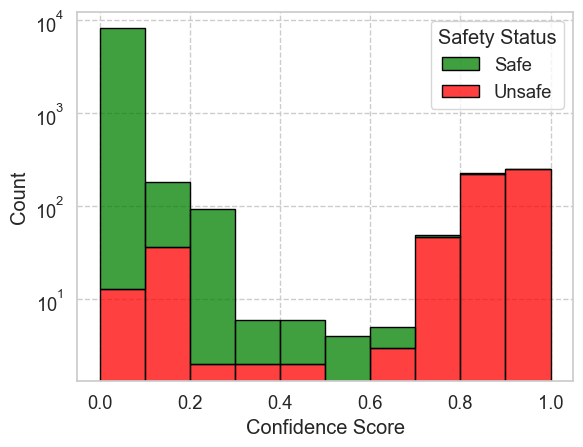

In [34]:
sns.set_theme(font_scale=1.2)
sns.set_style('whitegrid', {'grid.linestyle': '--'})

custom_color = {'Unsafe': 'red', 'Safe': 'green'}

ax = sns.histplot(data=result_df, x='prediction', hue='target', bins=10, multiple='stack', edgecolor='black', palette=custom_color)

plt.xlabel('Confidence Score')
plt.yscale('log')

ax.legend_.set_title('Safety Status')

Best Threshold: 0.610
Best F1 Score: 0.9423


Text(0, 0.5, 'Score')

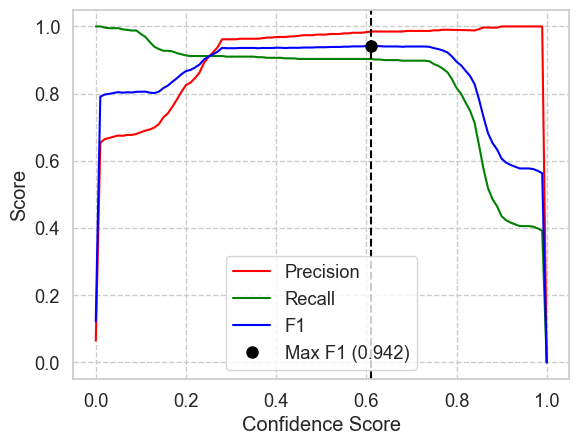

In [35]:
thr_val_arr = np.arange(0.0, 1.01, 0.01)

precision_arr = []
recall_arr = []
f1_arr = []

for thr_val in thr_val_arr:
    val_pred_binary = np.where(val_pred > thr_val, 1, 0)
    precision = precision_score(val_target, val_pred_binary, zero_division=0)
    recall = recall_score(val_target, val_pred_binary, zero_division=0)
    f1 = f1_score(val_target, val_pred_binary, zero_division=0)

    precision_arr.append(precision)
    recall_arr.append(recall)
    f1_arr.append(f1)

precision_arr = np.array(precision_arr)
recall_arr = np.array(recall_arr)
f1_arr = np.array(f1_arr)

sns.set_theme(font_scale=1.2)
sns.set_style('whitegrid', {'grid.linestyle': '--'})

sns.lineplot(x=thr_val_arr, y=precision_arr, color='red', label='Precision')
sns.lineplot(x=thr_val_arr, y=recall_arr, color='green', label='Recall')
sns.lineplot(x=thr_val_arr, y=f1_arr, color='blue', label='F1')

# 1. 최대 F1 점수의 인덱스 찾기
best_f1_index = np.argmax(f1_arr)

# 2. 해당 인덱스의 Threshold 값과 F1 점수 찾기
best_threshold = thr_val_arr[best_f1_index]
best_f1_score = f1_arr[best_f1_index]

# 3. 콘솔에 최적 값 출력
print(f"Best Threshold: {best_threshold:.3f}")
print(f"Best F1 Score: {best_f1_score:.4f}")

plt.axvline(x=best_threshold, color='black', linestyle='--')

# 5. F1 곡선 위에 최대 지점을 원(marker)으로 표시
plt.plot(best_threshold, best_f1_score, 'o', color='black', markersize=8,
         markeredgecolor='black', label=f'Max F1 ({best_f1_score:.3f})')

plt.legend()

plt.xlabel('Confidence Score')
plt.ylabel('Score')

([<matplotlib.axis.YTick at 0x24687f2ef50>,
 [Text(0, 0.5, 'Safe(0)'), Text(0, 1.5, 'Unsafe(1)')])

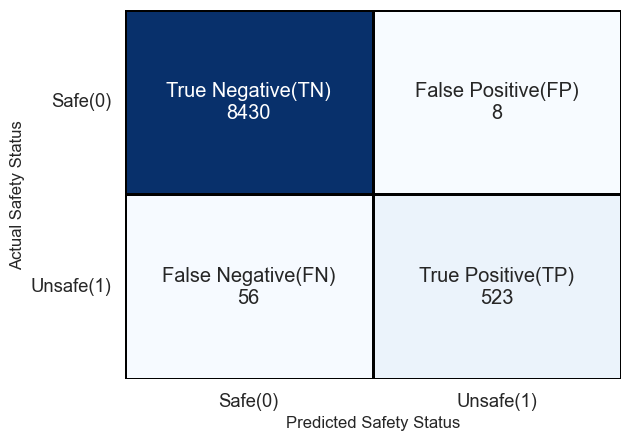

In [36]:
val_pred_binary = np.where(val_pred > best_threshold, 1, 0)

cm = confusion_matrix(val_target, val_pred_binary)

labels = np.array([[f'True Negative(TN)\n{cm[0, 0]}', f'False Positive(FP)\n{cm[0, 1]}'],
                   [f'False Negative(FN)\n{cm[1, 0]}', f'True Positive(TP)\n{cm[1, 1]}']])

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, linecolor='black', linewidths=1)

plt.ylabel('Actual Safety Status', fontsize=12)
plt.xlabel('Predicted Safety Status', fontsize=12)

plt.xticks([0.5, 1.5], ['Safe(0)', 'Unsafe(1)'])
plt.yticks([0.5, 1.5], ['Safe(0)', 'Unsafe(1)'], rotation=0, va='center')

In [37]:
print(precision_score(val_target, val_pred_binary))
print(recall_score(val_target, val_pred_binary))
print(f1_score(val_target, val_pred_binary))

0.9849340866290018
0.9032815198618307
0.9423423423423424


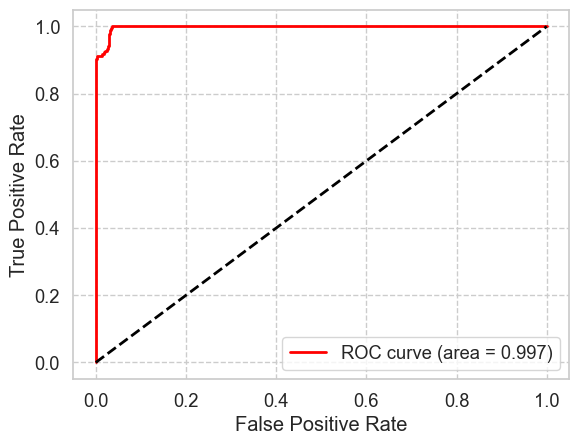

In [45]:
auc = roc_auc_score(y_true=val_target, y_score=val_pred)
fpr, tpr, thresholds = roc_curve(y_true=val_target, y_score=val_pred)

# 그래프 그리기
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {auc:.3f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--') # 50% 수준의 랜덤 모델
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)

(8500.0, 9000.0)

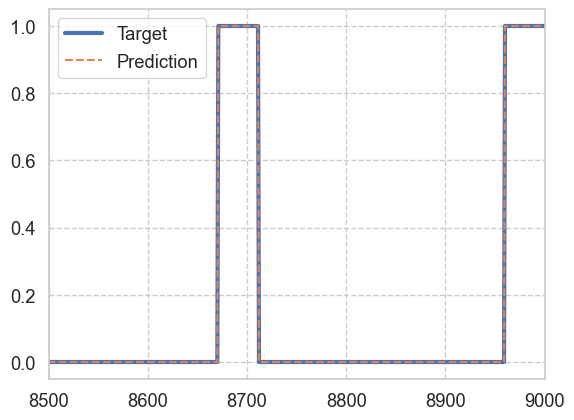

In [46]:
false_negative_list = []

for i, target in enumerate(val_target):
    b = val_pred_binary[i]
    a = np.array([target, b]) == [1, 0]
    a = np.all(a)
    false_negative_list.append(a.astype(int))

sns.lineplot(val_target, linewidth=3, label='Target')
sns.lineplot(val_pred_binary, linestyle='--', label='Prediction')

plt.xlim(8500, 9000)

In [40]:
result_list = []
count = 0

for i in range(len(val_target)):
    if i > 1:
        a = [val_target[i-1], val_target[i]]
        rising_edge = np.all(a==[0, 1])

        if rising_edge:
            count += 1
            result_list.append((i, count))

result_list

[(4727, 1),
 (5001, 2),
 (5292, 3),
 (5966, 4),
 (6276, 5),
 (6579, 6),
 (6889, 7),
 (7189, 8),
 (7559, 9),
 (7838, 10),
 (8126, 11),
 (8335, 12),
 (8671, 13),
 (8960, 14)]

In [41]:
def find_pulses_numpy(data):
    padded_data = np.concatenate(([0], data, [0]))
    diff = np.diff(padded_data)

    rising_indices = np.where(diff == 1)[0]
    falling_indices = np.where(diff == -1)[0]

    durations = falling_indices - rising_indices

    return list(zip(rising_indices, durations))

In [42]:
target_find = find_pulses_numpy(val_target)
pred_find = find_pulses_numpy(val_pred_binary)

In [43]:
time_diff_list = []
len_diff_list = []

for i in range(len(target_find)):
    time_diff = target_find[i][0] - pred_find[i][0]
    len_diff = target_find[i][1] - pred_find[i][1]

    time_diff_list.append(time_diff)
    len_diff_list.append(len_diff)

time_diff_list = np.array(time_diff_list)/10
len_diff_list = np.array(len_diff_list)/10

Text(0, 0.5, 'Difference of Duration(sec)')

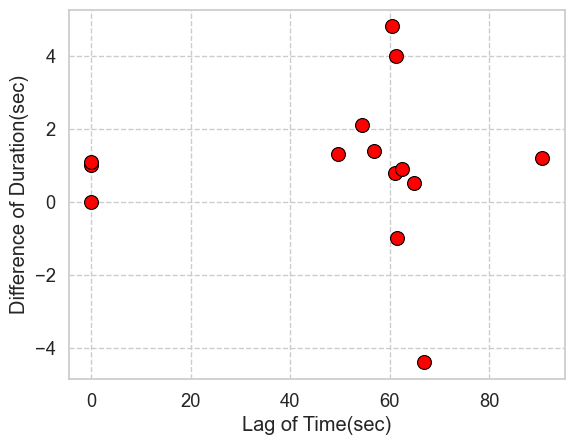

In [44]:
sns.scatterplot(x=time_diff_list, y=len_diff_list, color='red', edgecolor='black', s=100)

plt.xlabel('Lag of Time(sec)')
plt.ylabel('Difference of Duration(sec)')